In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

C:\Users\leopu\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch version: 2.1.2+cu121
torchvision version: 0.16.2+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x268e59b91f0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

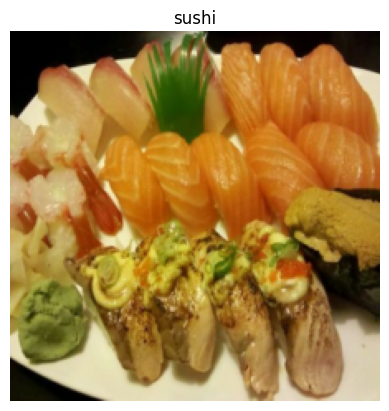

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [10]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [11]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


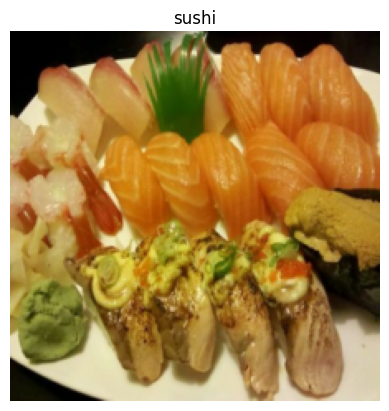

In [12]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

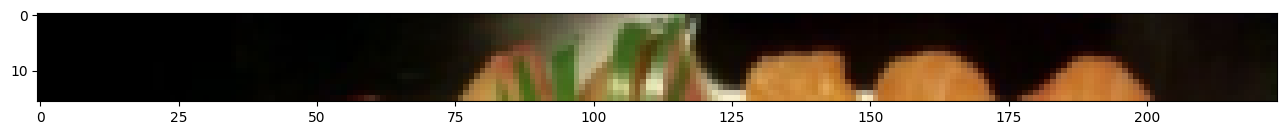

In [13]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


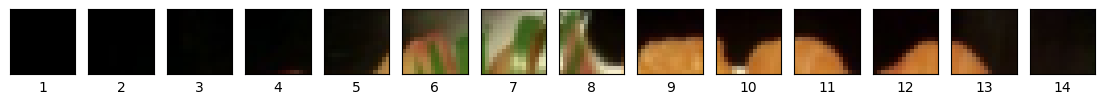

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


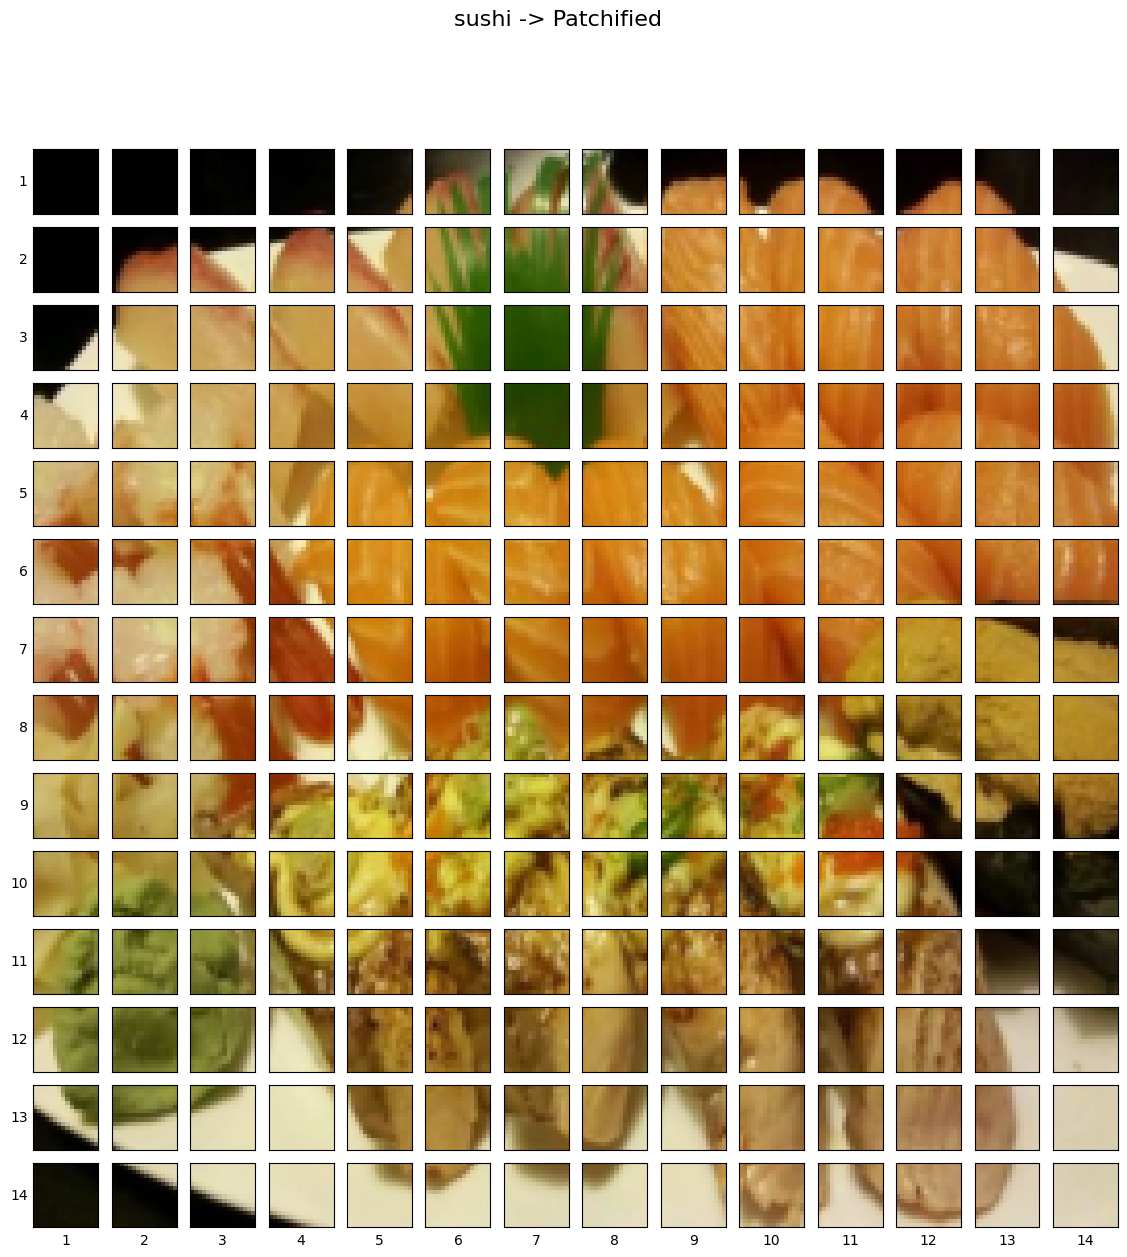

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [16]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

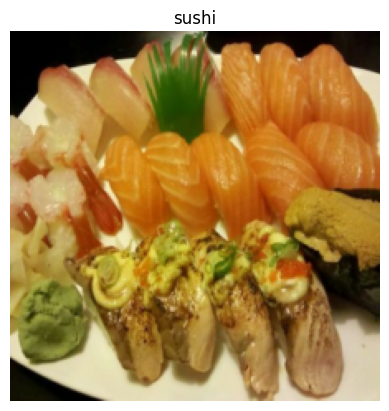

In [17]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

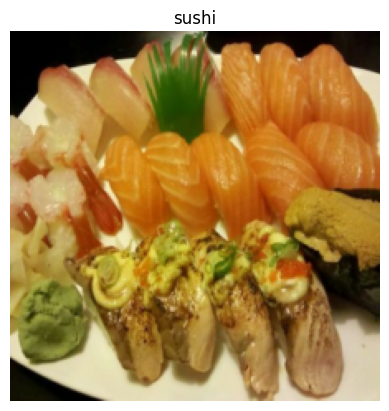

In [18]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [19]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [643, 93, 377, 460, 607]


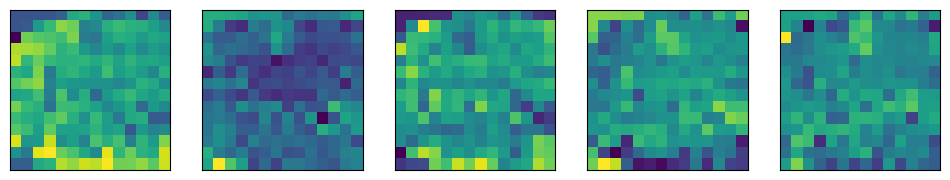

In [20]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [21]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0309, -0.0312, -0.0299, -0.0187,  0.0306, -0.1162, -0.2190,
           -0.1790,  0.1820,  0.3017,  0.0576,  0.1961,  0.0484, -0.0448],
          [-0.0304,  0.0651, -0.1051, -0.2456, -0.5772, -0.2751, -0.2222,
           -0.2940, -0.4134, -0.3027, -0.3692, -0.3575, -0.2369,  0.0408],
          [ 0.0020, -0.1971, -0.3689, -0.3488, -0.3829, -0.2153, -0.1032,
           -0.1646, -0.3839, -0.3414, -0.3934, -0.3349, -0.3845, -0.4389],
          [-0.3709, -0.5275, -0.3647, -0.3538, -0.3550, -0.2432,  0.0114,
           -0.1642, -0.2529, -0.2733, -0.2363, -0.2474, -0.2520, -0.3271],
          [-0.4237, -0.4390, -0.4231, -0.1592, -0.3501, -0.3132, -0.2715,
           -0.3377, -0.3085, -0.3370, -0.2622, -0.3344, -0.3059, -0.3117],
          [-0.1906, -0.1787, -0.2514, -0.4287, -0.3847, -0.3352, -0.3190,
           -0.3405, -0.3658, -0.3120, -0.3914, -0.3033, -0.3757, -0.3532],
          [-0.4134, -0.4936, -0.4819, -0.2874, -0.3542, -0.3130, -0.3294,
           -0.2784, -0.3137, -0.

In [22]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [23]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


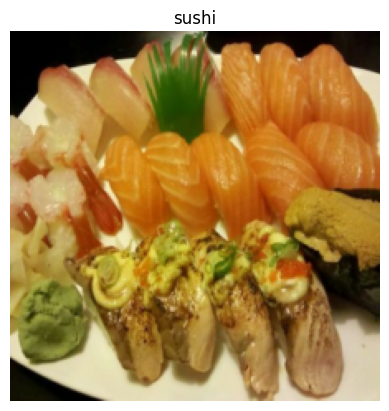

In [24]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [25]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


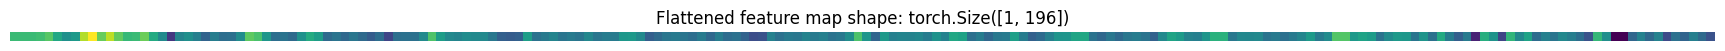

In [26]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [27]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.0309, -0.0312, -0.0299, -0.0187,  0.0306, -0.1162, -0.2190, -0.1790,
           0.1820,  0.3017,  0.0576,  0.1961,  0.0484, -0.0448, -0.0304,  0.0651,
          -0.1051, -0.2456, -0.5772, -0.2751, -0.2222, -0.2940, -0.4134, -0.3027,
          -0.3692, -0.3575, -0.2369,  0.0408,  0.0020, -0.1971, -0.3689, -0.3488,
          -0.3829, -0.2153, -0.1032, -0.1646, -0.3839, -0.3414, -0.3934, -0.3349,
          -0.3845, -0.4389, -0.3709, -0.5275, -0.3647, -0.3538, -0.3550, -0.2432,
           0.0114, -0.1642, -0.2529, -0.2733, -0.2363, -0.2474, -0.2520, -0.3271,
          -0.4237, -0.4390, -0.4231, -0.1592, -0.3501, -0.3132, -0.2715, -0.3377,
          -0.3085, -0.3370, -0.2622, -0.3344, -0.3059, -0.3117, -0.1906, -0.1787,
          -0.2514, -0.4287, -0.3847, -0.3352, -0.3190, -0.3405, -0.3658, -0.3120,
          -0.3914, -0.3033, -0.3757, -0.3532, -0.4134, -0.4936, -0.4819, -0.2874,
          -0.3542, -0.3130, -0.3294, -0.2784, -0.3137, -0.2915, -0.3451, -0.3258,
          -0.233

In [28]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [29]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [30]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
# summary(PatchEmbedding(),
#         input_size=random_input_image, # try swapping this for "random_input_image_error"
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [31]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0197, -0.0104, -0.0309,  ...,  0.0124, -0.0030,  0.0029],
         [-0.0311, -0.0065, -0.0323,  ...,  0.0187, -0.0050,  0.0084],
         ...,
         [-0.6839,  0.1582, -0.1657,  ...,  0.4316, -0.2880,  0.1454],
         [-0.7594,  0.3401, -0.2954,  ...,  0.6222, -0.3038,  0.1359],
         [-0.8425,  0.2124, -0.2421,  ...,  0.6287, -0.3926,  0.3055]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [32]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [33]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0197, -0.0104, -0.0309,  ...,  0.0124, -0.0030,  0.0029],
         ...,
         [-0.6839,  0.1582, -0.1657,  ...,  0.4316, -0.2880,  0.1454],
         [-0.7594,  0.3401, -0.2954,  ...,  0.6222, -0.3038,  0.1359],
         [-0.8425,  0.2124, -0.2421,  ...,  0.6287, -0.3926,  0.3055]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [34]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
          [-0.0197, -0.0104, -0.0309,  ...,  0.0124, -0.0030,  0.0029],
          ...,
          [-0.6839,  0.1582, -0.1657,  ...,  0.4316, -0.2880,  0.1454],
          [-0.7594,  0.3401, -0.2954,  ...,  0.6222, -0.3038,  0.1359],
          [-0.8425,  0.2124, -0.2421,  ...,  0.6287, -0.3926,  0.3055]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [35]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [36]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9812, 0.9886, 0.9689,  ..., 1.0105, 0.9967, 1.0033],
         [0.9803, 0.9896, 0.9691,  ..., 1.0124, 0.9970, 1.0029],
         ...,
         [0.3161, 1.1582, 0.8343,  ..., 1.4316, 0.7120, 1.1454],
         [0.2406, 1.3401, 0.7046,  ..., 1.6222, 0.6962, 1.1359],
         [0.1575, 1.2124, 0.7579,  ..., 1.6287, 0.6074, 1.3055]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [37]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [38]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [39]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9812, 0.9886, 0.9689,  ..., 1.0105, 0.9967, 1.0033],
         [0.9803, 0.9896, 0.9691,  ..., 1.0124, 0.9970, 1.0029],
         ...,
         [0.3161, 1.1582, 0.8343,  ..., 1.4316, 0.7120, 1.1454],
         [0.2406, 1.3401, 0.7046,  ..., 1.6222, 0.6962, 1.1359],
         [0.1575, 1.2124, 0.7579,  ..., 1.6287, 0.6074, 1.3055]]],
       grad_fn=<AddBackward0>)

In [40]:
patched_image_through_msa_block

tensor([[[-0.1467, -0.2417,  0.0419,  ..., -0.3567,  0.8171, -0.3914],
         [-0.1598, -0.2584,  0.0412,  ..., -0.3445,  0.8144, -0.3948],
         [-0.1590, -0.2584,  0.0415,  ..., -0.3442,  0.8145, -0.3951],
         ...,
         [-0.1150, -0.2252,  0.0496,  ..., -0.3540,  0.8289, -0.4041],
         [-0.1185, -0.2303,  0.0507,  ..., -0.3554,  0.8323, -0.4071],
         [-0.1162, -0.2273,  0.0498,  ..., -0.3587,  0.8336, -0.4049]]],
       grad_fn=<TransposeBackward0>)

In [41]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 mlp_size: int=3072,
                 dropout: float=0.1
                 ):
        super().__init__()
        
        # Create a norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # Create the MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout()
        )
        
    def forward(self, x):
        return self.mlp(self.layer_norm(x))

In [42]:
mlp_block = MLPBlock()

# Pass the output of the MSA block through MLP
patch_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
patch_image_through_mlp_block

tensor([[[-0.0338, -0.0769,  0.0000,  ...,  0.0000, -0.3413,  0.4601],
         [-0.0000, -0.0000,  0.6374,  ..., -0.1484, -0.0000,  0.0000],
         [ 0.0707, -0.0000,  0.0000,  ..., -0.0000, -0.4156,  0.0000],
         ...,
         [-0.2525, -0.0000,  0.0000,  ...,  0.1961, -0.4296,  0.0000],
         [-0.1053,  0.0000,  0.0000,  ...,  0.0000, -0.3561,  0.0000],
         [-0.0000, -0.0836,  0.0000,  ..., -0.2202, -0.0000,  0.0000]]],
       grad_fn=<MulBackward0>)

## Creating an Encoder

In [51]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, 
                embedding_dim: int=768,
                num_heads:int=12,
                mlp_size:int=3072,
                mlp_dropout:float=0.1,
                attn_dropout:float=0.0):
        super().__init__()
        
        # Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            attn_dropout=attn_dropout
            )
        
        # Create MLP block equation 3
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim,
            mlp_size=mlp_size,
            dropout=mlp_dropout
        )
    
    def forward(self, x):
        x = self.msa_block(x) + x 
        x = self.mlp_block(x) + x
        return x

In [57]:
transformer_encoder_block = TransformerEncoderBlock()
summary(
    model=transformer_encoder_block, 
    input_size=(1, 197, 768), 
    col_names=["input_size", "output_size", "num_params", "trainable"], 
    col_width=15, 
    row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape     Output Shape    Param #         Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]   [1, 197, 768]   --              True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]   [1, 197, 768]   --              True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]   [1, 197, 768]   1,536           True
│    └─MultiheadAttention (multihead_attn)         --              [1, 197, 768]   2,362,368       True
├─MLPBlock (mlp_block)                             [1, 197, 768]   [1, 197, 768]   --              True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]   [1, 197, 768]   1,536           True
│    └─Sequential (mlp)                            [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─Linear (0)                             [1, 197, 768]   [1, 197, 3072]  2,362,368       True
│    │    └─GELU (1)                               [1, 197,

In [58]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768, 
    nhead=12, 
    dim_feedforward=3072,
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True
)

summary(
    model=torch_transformer_encoder_layer, 
    input_size=(1, 197, 768), 
    col_names=["input_size", "output_size", "num_params", "trainable"], 
    col_width=15, 
    row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape     Output Shape    Param #         Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]   [1, 197, 768]   7,087,872       True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61